In [1]:
import sys
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

In [2]:
def sigma_ellipse(p, cov, n): 
    eig_vals, eig_vec = np.linalg.eig(cov) #固有値と固有ベクトルを計算する
    ang = math.atan2(eig_vec[:,0][1], eig_vec[:,0][0])/math.pi*180 #楕円の傾きを計算する
    return Ellipse(p, width=n*math.sqrt(eig_vals[0]),height=n*math.sqrt(eig_vals[1]), angle=ang, fill=False, color="blue", alpha=0.5) #楕円を返す

In [3]:
class KalmanFilter: ###kf4init
    def __init__(self, envmap, init_pose, motion_noise_stds, distance_dev_rate=0.14, direction_dev=0.05): #変数追加
        self.belief = multivariate_normal(mean=init_pose, \
                                        cov=np.diag([1e-10, 1e-10, 1e-10])) #信念の初期の共分散行列を設定 #初期位置から初期平均値を設定
        self.motion_noise_stds = motion_noise_stds #雑音を渡す
        self.map = envmap  #地図
        self.distance_dev_rate = distance_dev_rate 
        self.direction_dev = direction_dev #ランドマークの方角の標準偏差
        
    def observation_update(self, observation):  #観測値から信念を更新する
        for d in observation:
            z = d[0]
            obs_id = d[1]
            
            ###Hの計算###
            mx, my = self.map.landmarks[obs_id].pos #地図上のランドマークの位置を取得
            mux, muy, mut = self.belief.mean #それぞれ平均を取得
            q = (mux - mx)**2 + (muy - my)**2
            sqrtq = np.sqrt(q)
            H = np.array([[(mux - mx)/sqrtq, (muy - my)/sqrtq, 0.0],  [(my - muy)/q, (mux - mx)/q, -1.0]]) #補正するための行列Hを計算
            
            ###Qの計算###
            hmu = IdealCamera.relative_polar_pos(self.belief.mean, self.map.landmarks[obs_id].pos) #ランドマークの距離と方角を取得
            distance_dev = self.distance_dev_rate*hmu[0] #ランドマークまでの距離の標準偏差を計算
            Q = np.diag(np.array([distance_dev**2, self.direction_dev**2])) #観測したランドマークの共分散行列Qを標準偏差から計算
            
            ###カルマンゲインの計算###
            K = self.belief.cov.dot(H.T).dot(np.linalg.inv(Q + H.dot(self.belief.cov).dot(H.T)))
            #カルマンゲインが大きいほどランドマークを観測した後の信念が大きく補正される
            
            ###更新###
            self.belief.mean += K.dot(z - hmu) #観測値を反映する前の平均にたして更新
            self.belief.cov = (np.eye(3) - K.dot(H)).dot(self.belief.cov) #共分散行列の更新
        
    def motion_update(self, nu, omega, time):
        if abs(omega) < 1e-5: omega = 1e-5 #Fはω=0のときに式が変わるのでそれを避ける
        if abs(nu) < 1e-5:         nu = 1e-5 

        v = self.motion_noise_stds #雑音
        M = np.diag([v["nn"]**2*abs(nu)/time + v["no"]**2*abs(omega)/time, #実際の出力utの共分散行列Mtを計算する
                     v["on"]**2*abs(nu)/time + v["oo"]**2*abs(omega)/time]) #二乗して標準偏差を分散にする
        
        t = self.belief.mean[2] #姿勢の平均を取得
        st, ct = math.sin(t), math.cos(t)
        stw, ctw = math.sin(t + omega*time), math.cos(t + omega*time) 
        A = np.array([[(stw - st)/omega,    -nu/(omega**2)*(stw - st) + nu/omega*time*ctw], #実際の制御入力との差によって姿勢を補正するる
                                 [(-ctw + ct)/omega, -nu/(omega**2)*(-ctw + ct) + nu/omega*time*stw],
                                 [0,                                time]] )
        
        F = np.diag([1.0, 1.0, 1.0]) #行列Fを計算する #行列Fは平均とxt-1の距離によって状態遷移を補正する
        F[0, 2] = nu / omega * (math.cos(t + omega * time) - math.cos(t))
        F[1, 2] = nu / omega * (math.sin(t + omega * time) - math.sin(t))
            
        self.belief.cov = F.dot(self.belief.cov).dot(F.T) + A.dot(M).dot(A.T) #観測値を反映する前の信念の共分散行列の更新
        self.belief.mean = IdealRobot.state_transition(nu, omega, time, self.belief.mean) #観測値を反映する前の平均の更新
        
    def draw(self, ax, elems):
        e = sigma_ellipse(self.belief.mean[0:2], self.belief.cov[0:2, 0:2], 3) #誤差の3シグマ範囲の楕円を描画
        elems.append(ax.add_patch(e))

        ###θ方向の誤差の3シグマ範囲###
        x, y, c = self.belief.mean #それぞれ平均を取得
        sigma3 = math.sqrt(self.belief.cov[2, 2])*3 #3シグマを計算
        xs = [x + math.cos(c-sigma3), x, x + math.cos(c+sigma3)] #平均から3シグマずつの角度に線を引く
        ys = [y + math.sin(c-sigma3), y, y + math.sin(c+sigma3)]
        elems += ax.plot(xs, ys, color="blue", alpha=0.5)

In [4]:
class KfAgent(Agent): 
    def __init__(self, time_interval, nu, omega, init_pose, envmap, \
                motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}): #雑音の標準偏差を設定
                            
        super().__init__(nu, omega)
        self.kf = KalmanFilter(envmap, init_pose, motion_noise_stds)
        self.time_interval = time_interval
        
        self.prev_nu = 0.0 #
        self.prev_omega = 0.0
        
    def decision(self, observation=None):  ###kfagent2
        self.kf.motion_update(self.prev_nu, self.prev_omega, self.time_interval) 
        self.prev_nu, self.prev_omega = self.nu, self.omega
        self.kf.observation_update(observation)
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.kf.draw(ax, elems)

<IPython.core.display.Javascript object>


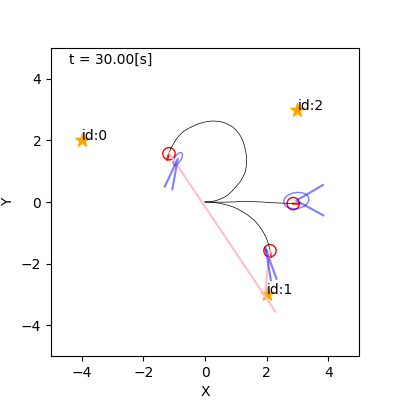

In [5]:
if __name__ == '__main__': 
    time_interval = 0.1 #実行する間隔
    world = World(30, time_interval) #実行時間と実行する間隔をわたす

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()                                  
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ### ロボットを作る ###
    circling = KfAgent(time_interval, 0.2, 10.0/180*math.pi, np.array([0, 0, 0]).T, m)
    r = Robot(np.array([0, 0, 0]).T, sensor=Camera(m), agent=circling, color="red")
    world.append(r)
    linear = KfAgent(time_interval, 0.1, 0.0, np.array([0, 0, 0]).T, m)
    r = Robot(np.array([0, 0, 0]).T, sensor=Camera(m), agent=linear, color="red")
    world.append(r)
    right = KfAgent(time_interval, 0.1, -3.0/180*math.pi, np.array([0, 0, 0]).T, m)
    r = Robot(np.array([0, 0, 0]).T, sensor=Camera(m), agent=right, color="red")
    world.append(r)

    world.draw()                       # アニメーションさせるとき
   # r.one_step(time_interval)  # アニメーションなしでデバッグするとき